#### WHY this notebook?

We wanted to use backes % labels to guide model learning. However, when matthias generated the ground truths, they seemed to differ from the labels that backe gave quite substantially. 

In [2]:
import rasterio
import rasterio.plot

test_gt = rasterio.open(
    "/home/nadjaflechner/Palsa_data/generated_datasets/FINALFINAL_200m_groundtruths/groundtruth_mask/753_67_2550_2014_crop_63.tif")
test_rgb = rasterio.open(
    "/home/nadjaflechner/Palsa_data/generated_datasets/FINALFINAL_200m_groundtruths/rgb/753_67_2550_2014_crop_63.tif")

In [4]:
test_gt.bounds

BoundingBox(left=675600.0, bottom=7533500.0, right=675800.0, top=7533700.0)

### What percentage did Backe identify?

The 200x200 image above is labeled (by my generation) as having 64.75%  palsa.\
I wanted to verify this by checking it manually (using the location inferred from the bounds).\
So i found the area:

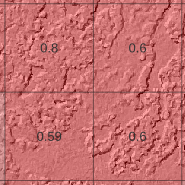

As we can see, the 200x200 area has (0.8+0.6+0.6+0.59)/4 as percentage, \
which equals = 64.75
Hence my calculation of the % based on backe is correct. 

### What percentage did Matthias' method identify?

percentage segmented by Matthias = 14.04


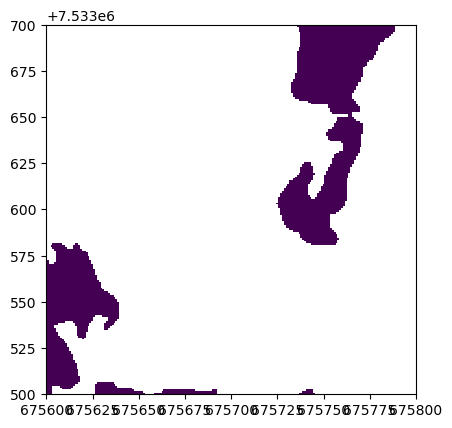

<Axes: >

In [8]:
test_gt = rasterio.open(
    "/home/nadjaflechner/Palsa_data/generated_datasets/FINALFINAL_200m_groundtruths/groundtruth_mask/753_67_2550_2014_crop_63.tif")
img = test_gt.read()
palsa_pixels = img.sum()
total_pixels = img.shape[-1]*img.shape[-2]
percent = palsa_pixels/total_pixels * 100

print(f'percentage segmented by Matthias = {percent.round(2)}')

rasterio.plot.show(test_gt)

### Generate Backe vs Matthias comparison array

In [29]:
import pandas as pd
import os

root_dir = '/home/nadjaflechner/Palsa_data/generated_datasets/FINALFINAL_200m_groundtruths/'
labels_df = pd.read_csv(os.path.join(root_dir, 'palsa_labels.csv'), index_col=0)
positive_labels = labels_df[labels_df['palsa_percentage']>0]

def matthias_percentage(filename):
    gt_filename = os.path.join(root_dir, f'groundtruth_mask/{filename}.tif')
    test_gt = rasterio.open(gt_filename)
    img = test_gt.read()
    palsa_pixels = img.sum()
    total_pixels = img.shape[-1]*img.shape[-2]
    percent = palsa_pixels/total_pixels * 100
    return percent

positive_labels['matthias_percentage'] = positive_labels.index.map(matthias_percentage)

/tmp/ipykernel_20109/3960942162.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_labels['matthias_percentage'] = positive_labels.index.map(matthias_percentage)


In [33]:
positive_labels['difference'] = abs(positive_labels['palsa_percentage'] - positive_labels['matthias_percentage'])
positive_labels

/tmp/ipykernel_20109/2037973176.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_labels['difference'] = abs(positive_labels['palsa_percentage'] - positive_labels['matthias_percentage'])


,palsa_percentage,matthias_percentage,difference
757_69_5050_2014_crop_3,1.50,1.6100,0.1100
757_69_5050_2014_crop_4,1.75,4.1225,2.3725
757_69_5050_2014_crop_15,2.25,1.7400,0.5100
757_69_5050_2014_crop_16,8.50,3.4075,5.0925
757_69_5050_2014_crop_17,2.50,3.5725,1.0725
...,...,...,...
733_52_2500_2015_crop_10,0.75,0.0600,0.6900
733_52_2500_2015_crop_21,0.50,0.2850,0.2150
733_52_2500_2015_crop_23,0.25,0.5575,0.3075
733_52_2500_2015_crop_33,0.25,0.1825,0.0675


In [37]:
mean_diff = positive_labels['difference'].mean()
std_diff = positive_labels['difference'].std()

print(f'the mean difference was: {mean_diff}')
print(f'the std of difference was: {std_diff}')

the mean difference was: 4.039986631016043
the std of difference was: 7.993488237314742


In [38]:
max_diff = positive_labels['difference'].max()
biggerthan10diff = positive_labels.loc[positive_labels['difference']>10]

print(f'the max difference was: {max_diff}')
print(f'the number of samples that had >10% difference was: {len(biggerthan10diff)}')


the max difference was: 60.795
the number of samples that had >10% difference was: 20


### Visualizing the differences 

In [54]:
import matplotlib.pyplot as plt
import numpy as np

def plot_predictions(backe_estimates, matthias_estimates):
    # Create a figure and axis
    fig, ax = plt.subplots(figsize=(8, 8))

    # Plot the predicted values against the ground truth values as a scatter plot
    ax.scatter(backe_estimates, matthias_estimates, color='blue', label='Predictions')

    # Plot the identity function as a straight line
    min_value = min(min(backe_estimates), min(matthias_estimates))
    max_value = max(max(backe_estimates), max(matthias_estimates))
    identity_line = np.linspace(min_value, max_value, 100)
    ax.plot(identity_line, identity_line, color='red', linestyle='--', label='Identity')

    # Set the labels and title
    ax.set_ylabel('Matthias Estimates')
    ax.set_xlabel('Backe Estimates')
    ax.set_title('Backe Estimates vs. Matthias Estimates')

    # Add a legend
    ax.legend()

    # Display the plot
    plt.tight_layout()
    plt.show()

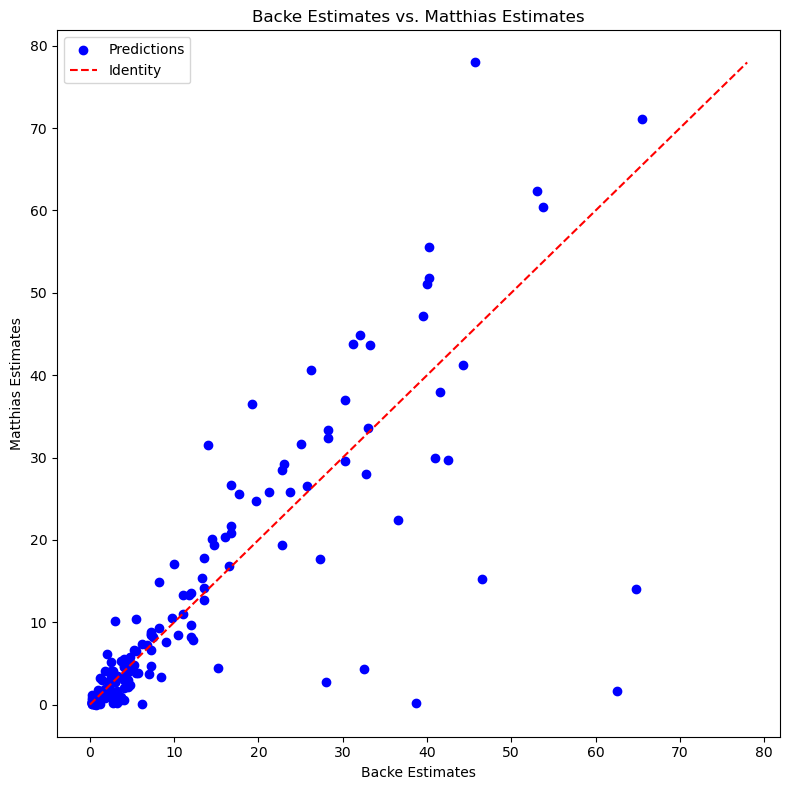

In [55]:
plot_predictions(positive_labels['palsa_percentage'], positive_labels['matthias_percentage'])

- We can see that especially on the lower end, the two overlap more or less. 
- When Backe estimates low palsa, Matthias tends to agree 
- However when Matthias estimates low palsa, Backe's estimates can be really high. 

#### What are the mean and std differences on the higher end? (above 20%)

In [60]:
above20_df = positive_labels.loc[positive_labels['palsa_percentage']>20]
above20_mean_diff = above20_df['difference'].mean()
above20_std_diff = above20_df['difference'].std()

print(f'the mean difference was: {above20_mean_diff.round(2)}')
print(f'the std of difference was: {above20_std_diff.round(2)}')

the mean difference was: 13.24
the std of difference was: 13.87


## Visually inspect samples with biggest difference for re-validation

In [62]:
biggerthan25diff = positive_labels.loc[positive_labels['difference']>25]

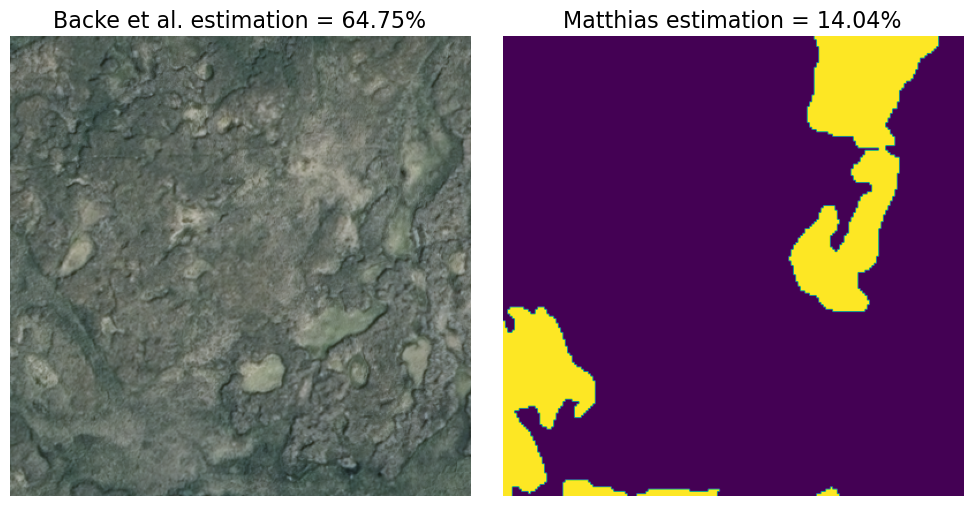

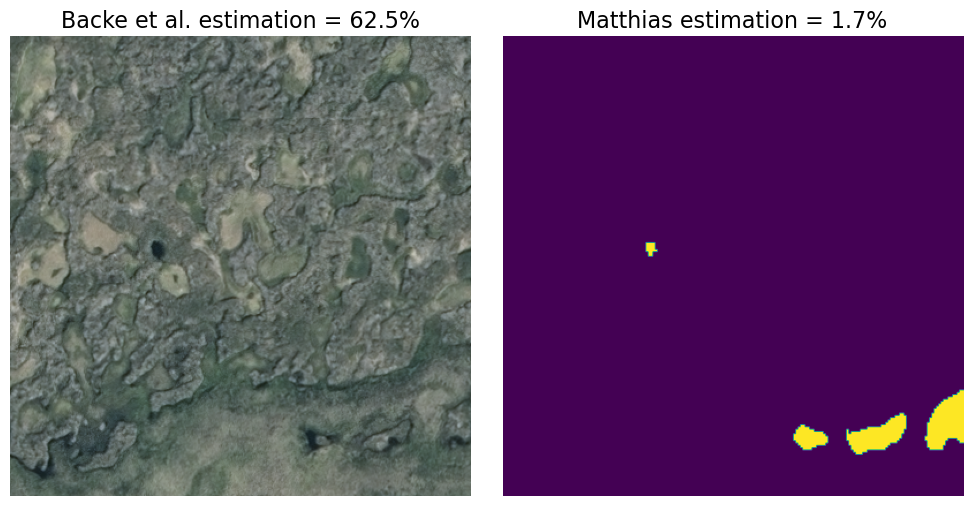

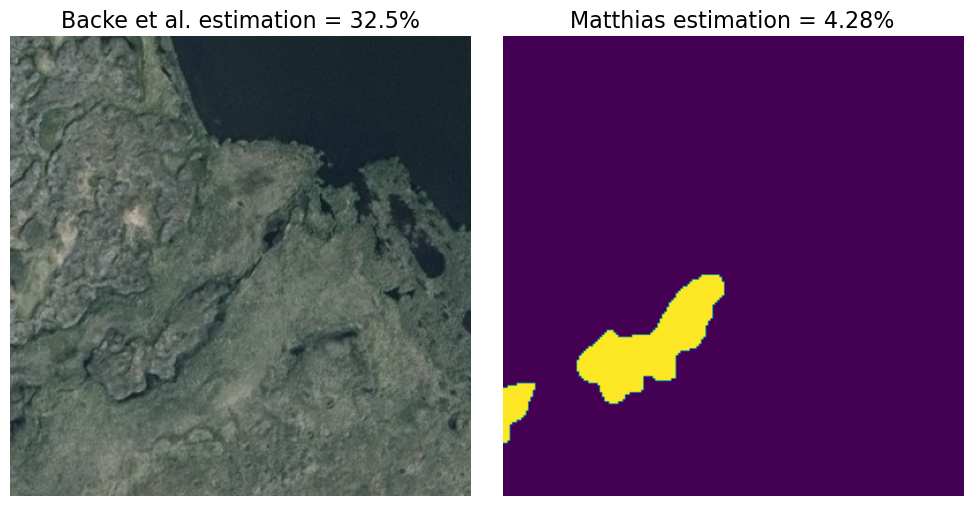

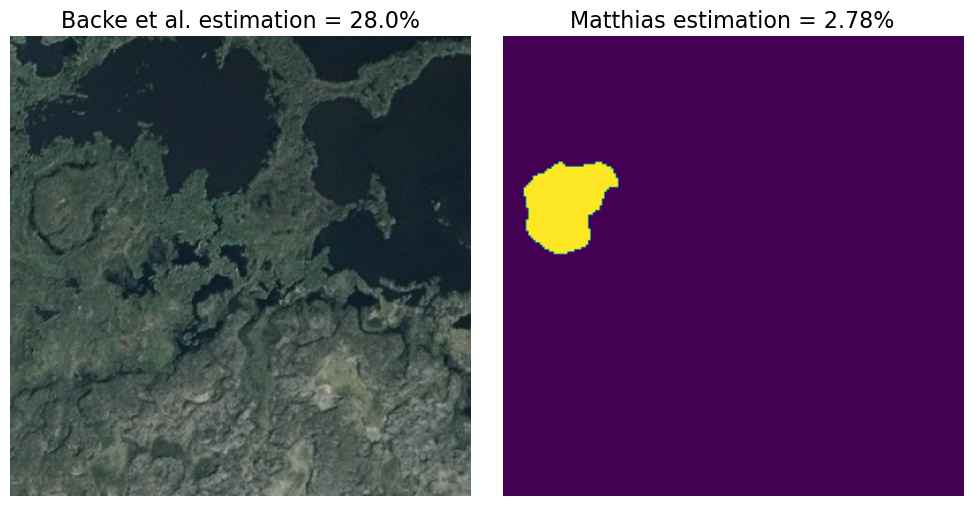

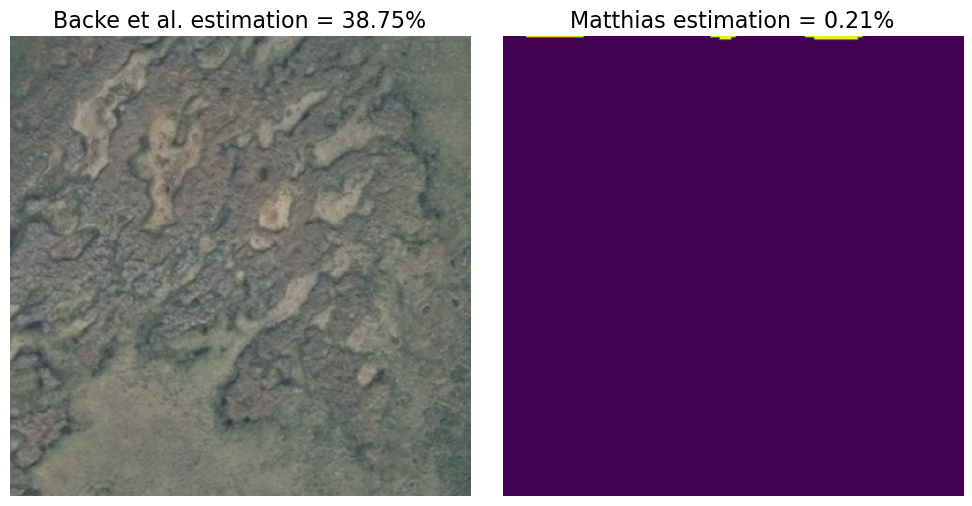

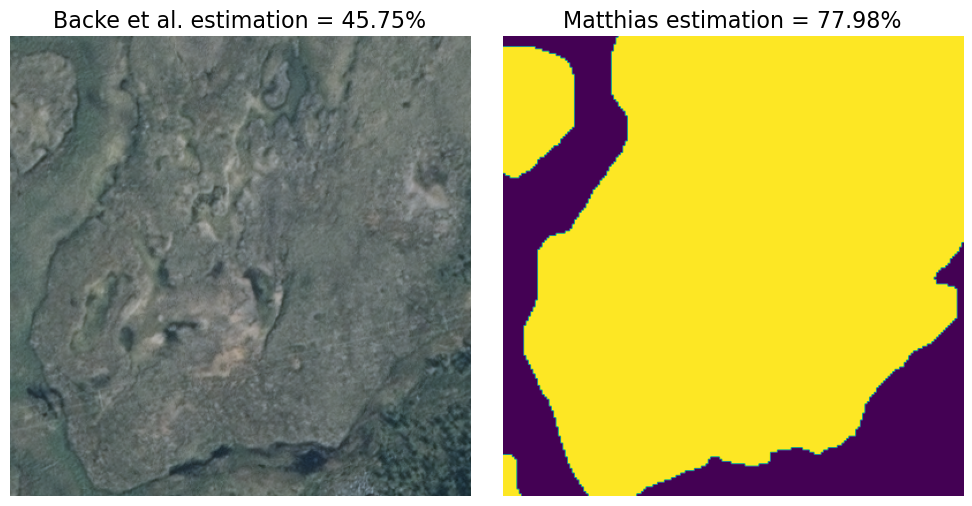

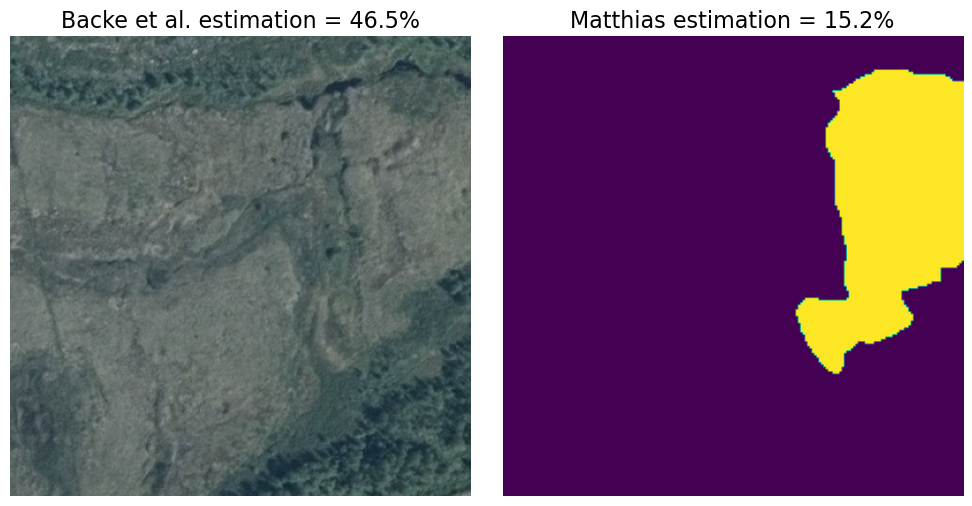

In [72]:
root_dir = '/home/nadjaflechner/Palsa_data/generated_datasets/FINALFINAL_200m_groundtruths/'

for filename in biggerthan25diff.index:
    gt_path = os.path.join(root_dir, f'groundtruth_mask/{filename}.tif')
    rgb_path = os.path.join(root_dir, f'rgb/{filename}.tif')

    with rasterio.open(gt_path) as gt, rasterio.open(rgb_path) as rgb:

        # Create a figure with two subplots side by side
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

        # Plot the second image
        ax1.imshow(rgb.read().transpose(1,2,0))
        ax1.axis('off')
        ax1_title = f'Backe et al. estimation = {biggerthan25diff['palsa_percentage'][filename]}%'
        ax1.set_title(ax1_title, fontsize=16)

        # Plot the first image
        ax2.imshow(gt.read(1))
        ax2.axis('off')
        ax2_title = f'Matthias estimation = {biggerthan25diff['matthias_percentage'][filename].round(2)}%'
        ax2.set_title(ax2_title, fontsize=16)

        # Adjust the spacing between subplots
        plt.tight_layout()

        # Display the plot
        plt.show()

## APPENDIX:

### Generate new palsa_labels.csv with these differences.


In [73]:
import pandas as pd
import os

root_dir = '/home/nadjaflechner/Palsa_data/generated_datasets/FINALFINAL_200m_groundtruths/'
new_labels_df = pd.read_csv(os.path.join(root_dir, 'palsa_labels.csv'), index_col=0)

def matthias_percentage(filename):
    gt_filename = os.path.join(root_dir, f'groundtruth_mask/{filename}.tif')
    test_gt = rasterio.open(gt_filename)
    img = test_gt.read()
    palsa_pixels = img.sum()
    total_pixels = img.shape[-1]*img.shape[-2]
    percent = palsa_pixels/total_pixels * 100
    return percent

new_labels_df['matthias_percentage'] = new_labels_df.index.map(matthias_percentage)
new_labels_df['difference'] = abs(new_labels_df['palsa_percentage'] - new_labels_df['matthias_percentage'])

new_labels_df.to_csv(os.path.join(root_dir, "new_palsa_labels.csv"))


In [84]:
new_labels_df.loc[(new_labels_df['difference']<10) & (new_labels_df['palsa_percentage']>0)]

,palsa_percentage,matthias_percentage,difference
757_69_5050_2014_crop_3,1.50,1.6100,0.1100
757_69_5050_2014_crop_4,1.75,4.1225,2.3725
757_69_5050_2014_crop_15,2.25,1.7400,0.5100
757_69_5050_2014_crop_16,8.50,3.4075,5.0925
757_69_5050_2014_crop_17,2.50,3.5725,1.0725
...,...,...,...
733_52_2500_2015_crop_10,0.75,0.0600,0.6900
733_52_2500_2015_crop_21,0.50,0.2850,0.2150
733_52_2500_2015_crop_23,0.25,0.5575,0.3075
733_52_2500_2015_crop_33,0.25,0.1825,0.0675


In [90]:
lessthan10 = new_labels_df.loc[(new_labels_df['difference']<10) & (new_labels_df['palsa_percentage']>0)]

In [97]:
lessthan10.loc[lessthan10['palsa_percentage']>5]

,palsa_percentage,matthias_percentage,difference
757_69_5050_2014_crop_16,8.50,3.4075,5.0925
757_69_5050_2014_crop_18,7.25,8.5750,1.3250
753_67_2550_2014_crop_51,41.50,37.9500,3.5500
753_67_2550_2014_crop_60,7.25,6.6025,0.6475
753_67_2550_2014_crop_61,13.50,12.7375,0.7625
...,...,...,...
758_66_5025_2010_crop_101,33.00,33.6325,0.6325
758_66_5025_2010_crop_104,8.25,14.8575,6.6075
758_66_5025_2010_crop_111,5.50,10.4125,4.9125
758_66_5025_2010_crop_112,17.75,25.5375,7.7875


In [91]:
lessthan5 = new_labels_df.loc[(new_labels_df['difference']<5) & (new_labels_df['palsa_percentage']>0)]

In [92]:
lessthan10.drop(lessthan5.index)

,palsa_percentage,matthias_percentage,difference
757_69_5050_2014_crop_16,8.50,3.4075,5.0925
758_71_0000_2013_crop_68,23.00,29.2775,6.2775
758_71_0000_2013_crop_81,28.25,33.3350,5.0850
760_74_5025_2018_crop_36,39.50,47.1525,7.6525
760_74_5025_2018_crop_37,25.00,31.6725,6.6725
760_74_5025_2018_crop_48,22.75,28.4775,5.7275
757_69_2575_2014_crop_14,14.50,20.1650,5.6650
765_74_2500_2016_crop_35,30.25,36.9500,6.7000
764_75_2500_2015_crop_76,53.75,60.3725,6.6225
764_75_2500_2015_crop_86,27.25,17.6550,9.5950


In [93]:
lessthan5

,palsa_percentage,matthias_percentage,difference
757_69_5050_2014_crop_3,1.50,1.6100,0.1100
757_69_5050_2014_crop_4,1.75,4.1225,2.3725
757_69_5050_2014_crop_15,2.25,1.7400,0.5100
757_69_5050_2014_crop_17,2.50,3.5725,1.0725
757_69_5050_2014_crop_18,7.25,8.5750,1.3250
...,...,...,...
733_52_2500_2015_crop_10,0.75,0.0600,0.6900
733_52_2500_2015_crop_21,0.50,0.2850,0.2150
733_52_2500_2015_crop_23,0.25,0.5575,0.3075
733_52_2500_2015_crop_33,0.25,0.1825,0.0675
